# pset08: the cycle of twelve
*by Xingyu (Luna) Li , Oct 31st, 2021*
  
## Background
Sand mouse cells have a circadian oscillator that partly depends on transcriptional regulation. The mRNA expression levels of twelve sand mouse genes are known to vary cyclically in a 24 hour period, in different phases. However, their phases relative to each other remain unknown.   
Our lab have collected a few published RNA-seq experiments in entrained sand mouse cells, at a small number of time points. There are a total of 8 experiments, with two experiments each at time points at 4, 8, 16, and 24 hours, as marked in the first line of bold column headers. The numbers in the table are estimated expression levels in TPM for the 12 genes.  
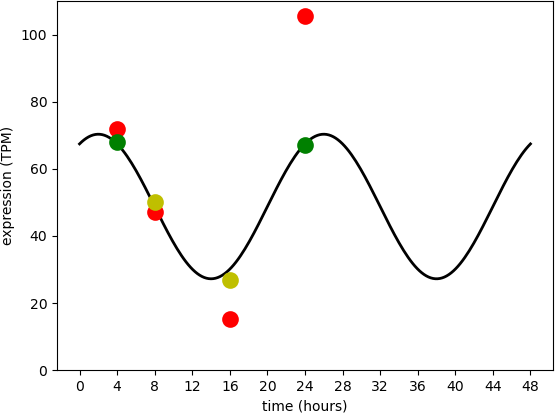  
  
We want to deduce the unknown phases ϕ, given this small amount of published RNA-seq data of variable reliability, and thereby deduce the correct relative order of the 12 genes. 
## 1. Solve by Maximum Likelihood
We are going to use maximum likelihood to solve for the unknown phases ϕ.

In [1]:
# Read the data
import numpy as np
def read_data(infile):
    t = []
    gene = []
    data  = []
    sigma = []
    with open(infile) as f:
        for line in f:
            fields = line.split()
            if line[0] == ' ': 
                times = line.split()
                for i in range(8):
                    t.append(int(''.join(filter(str.isdigit, times[i]))))
            elif line[0] == '-': continue
            elif fields[0] == 'gene':
                for sigmas in fields[1:]:
                    sigma.append(int(''.join(filter(str.isdigit, sigmas))))
            else:
                gene.append(fields[0])
                data.append( np.array( [ float(s) for s in fields[1:]] ))
    return t, gene, data, sigma

ts, genes, data, sigmas = read_data("w08-data.tbl")

First, we would calculate a log likelihood logP(data∣θ) for each gene independently. Since optimizers are typically written as minimizers, so we would write an objective function to return a negative log likelihood (NLL).

In [2]:
# Calculate the negative log likelihood of y_t = b + a * sin( 2πω ( t + ϕ ) )
import scipy.stats as stats

def nll(p, ts, exp, sigmas):
    a, b, phase = p
    pred = np.zeros(len(ts))
    ll = 0.
    for i, t in enumerate(ts):
        pred[i] = b + a * np.sin(2. * math.pi * (1 / 24) * (t + phase))
        ll += stats.norm.logpdf(exp[i] - pred[i], 0, sigmas[i])    
    return -ll

Next, we would use scipy.optimize.minimize to minimize our log-likelihood to  identify ML estimates â , b̂ , and ϕ̂  for each gene that maximize the log likelihood.

In [3]:
# The initial guess for a, b and phase
guess = np.array([1, 0, 0])

# Set the bounds so that a and ϕ are both positive and a is not 0
bounds = [(0.1,None), (None,None),(0.0,None)]

# Iterate through each genes
import math
import scipy.optimize as optimize
results = []
for gene in genes:
    minimization = optimize.minimize(nll, guess, (ts, data[genes.index(gene)], sigmas), bounds = bounds)
    results.append(minimization.x)

In [4]:
# Output the results
print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'a', 'b', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for i in range(len(results)):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genes[i], results[i][0], results[i][1], results[i][2]))

genename          a      b      p
------------ ------ ------ ------
anise         17.24  40.17  13.72
kiwi          21.21  41.52  29.74
carrot        34.68  44.65   4.16
grape         27.72  41.95  20.16
tangerine     26.24  40.93  15.99
melon         27.89  44.80  17.60
clementine    22.93  36.58   0.00
spinach       20.33  45.43  11.75
beet          21.38  41.58   7.54
huckleberry   22.24  42.49   9.95
lentil        31.01  43.18   0.00
cauliflower   27.01  39.70   2.10


Here we have estimated the â , b̂ , and ϕ̂ for each gene using the maximum likelihood method, we can then deduce the correct relative order of the 12 genes.   
For example, since *cauliflower* has a ϕ +2hrs of *lentil*, that means *cauliflower* starts to rise two hours before *lentil* does, and thus is more likely to be a direct regulator of *lentil* transcription, as opposed to the other way around.

## 2. Compare Solutions
The likelihood is defined as a probability: the probability of the data being generated by a model with specific parameter values: $P(\mathrm{data}|\mathrm{model},\theta=\theta_0)$.
Therefore, we could calculate the total log likelihood of our method and Moriaty's method to compare which is better.

In [5]:
# Ordinary least squares on: y_t = b + (a cos p) sin t + (a sin p) cos t
G = len(genes)
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)
results_ols = np.zeros((G,3))

for g in range(G):
    A = np.zeros((len(ts), 3))  # observations x coefficients
    for i,t in enumerate(ts):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * t / 24)  
        A[i][2] = np.cos(2. * math.pi * t / 24)

    try:
        result    = np.linalg.lstsq(A, data[g], rcond=-1)[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # in hours
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24

    results_ols[g][0] = a_fit[g]
    results_ols[g][1] = b_fit[g]
    results_ols[g][2] = p_fit[g]
    
# Output
print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'a', 'b', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for g in range(G):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genes[g], a_fit[g], b_fit[g], p_fit[g]))

genename          a      b      p
------------ ------ ------ ------
anise         16.61  38.76  14.44
kiwi          21.48  36.53   2.13
carrot        37.24  44.81   4.81
grape         21.31  46.05  19.76
tangerine     19.77  39.52  13.42
melon         28.86  44.01  18.22
clementine    27.75  41.89  21.39
spinach       22.72  43.27  11.75
beet          17.22  40.63   7.30
huckleberry   34.77  48.45  10.29
lentil        42.31  38.06  22.39
cauliflower   25.65  40.60  23.32


In [6]:
# Calculate the total log likelihood of Moriaty's method
lll_ols = 0
for i,p in enumerate(results_ols):
    lll_ols -= nll(p, ts, data[i],sigmas)
    
# Calculate the total log likelihood of our method
lll_ml = 0
for i,p in enumerate(results):
    lll_ml -= nll(p, ts, data[i],sigmas)

# Calculate the likelihood ratio
likelihood_ratio = np.exp(lll_ml - lll_ols)
print("Our ML fit parameters are {:.2e} times as likely as the OLS fit parameters used by Moriaty.".format(likelihood_ratio))

Our ML fit parameters are 1.92e+98 times as likely as the OLS fit parameters used by Moriaty.


A likelihood ratio could describe how much more likely it is that a model with parameter values $\theta_1$ will generate the observed data relative to the same model with parameter values $\theta_2$. 

Here, we compare how likely our ML-fit line is relative to Moriaty's OLS-fit line according to the likelihood function:

$$\mathrm{likelihood~ratio}=\frac{P(\mathrm{data}|\mathrm{ML~model},m=m_\mathrm{ML},b=b_\mathrm{ML})}{P(\mathrm{data}|\mathrm{OLS~model},m=m_\mathrm{OLS},b=b_\mathrm{OLS})}$$  
  
We could conclude that our maximum likelihood model is much more likely than the OLS model if we assume that the measurement errors given by the data file are correct.

## 3. Plot the Fits
For each of the 12 genes, we are going to plot the observed data and the two fits to show their difference.

In [7]:
# Calculate the predicted expression level using two methods
exp_ml = np.zeros((len(results),len(ts)))
for i, par in enumerate(results):
    for j,t in enumerate(ts):
        exp_ml[i][j] = par[1] + par[0] * np.sin(2. * math.pi * (1 / 24) * (t + par[2]))
    
exp_ols = np.zeros((len(results_ols),len(ts)))
for i, par in enumerate(results_ols):
    for j,t in enumerate(ts):
        exp_ols[i][j] = par[1] + par[0] * np.sin(2. * math.pi * (1 / 24) * (t + par[2]))

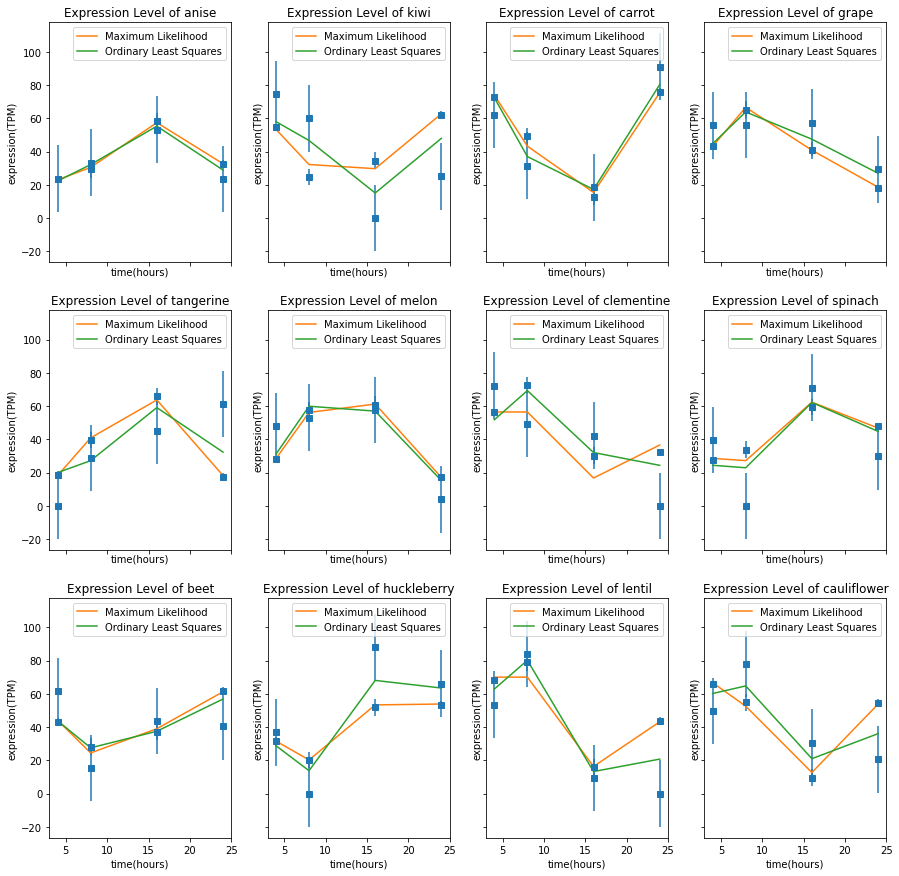

In [8]:
# Plot the fits
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,4, sharex=True, sharey=True, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    ax.errorbar(ts, data[i], sigmas, fmt="s")
    ax.plot(ts, exp_ml[i], label="Maximum Likelihood")
    ax.plot(ts, exp_ols[i], label="Ordinary Least Squares")
    ax.set_title("Expression Level of {}".format(genes[i]))
    ax.legend()
    ax.set_xlabel("time(hours)")
    ax.set_ylabel("expression(TPM)")
plt.show()

As can be seen from the plot, the fitting obtained by our maximum likelihood method better considers the accuracy of data at each time point, rather than simply adopting the hypothesis that the variances are all the same as what Moriaty did. Therefore, better results are obtained.